In [2]:
import sys, os
sys.path.append(os.path.join(os.getcwd().split('Documents')[0],'Documents/BecaNLP/Utils'))

import NLPUtils as nlp
import numpy as np
import pandas as pd

%load_ext autoreload
%autoreload 2

[nltk_data] Downloading package punkt to /home/lestien/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Naive Bayes + clasificación N, P, NONE, NEU + InterTASS 

Se hacen experimentos para la tarea de clasificación de sentimientos en las categorías N, P, None y Neu con el dataset InterTASSTask1. El modelo usado es Naive Bayes

## Pruebas en una grilla de parámetros

In [8]:
from NLPUtils.datasets import tass2018 as tass8
from NLPUtils.datasets import tass2019 as tass9
from NLPUtils.classification import MultinomialNB, BagOfNgramsVectorizer, get_score

#train_dataset = pd.concat([tass8.get_train_dataframe(lang=['es']), tass9.get_train_dataframe(lang=['es'])],ignore_index=True)
train_dataset = tass9.get_train_dataframe(lang=['es'])
dev_dataset = tass9.get_dev_dataframe(lang=['es'])

def label_fn(labels):
    labels_dict = {label: idx for idx, label in enumerate(np.unique(labels))}
    return np.array([labels_dict[label] for label in labels])

def parameter_grid(*params):
    params = [param.reshape(-1) for param in np.meshgrid(*params)]
    for param_tuple in zip(*params):
        yield param_tuple

min_ngrams = [2,3,4,5,6]
max_ngrams = [10,13,15,17,20]
maxs_features = [60000,65000,70000,75000,80000]
alphas = alphas = [.01, .02, .04, .08, .09, .1, .2, .4, .8, 1., 2., 4., 8.]
scores_train = {'acc': [], 'f1': [], 'params': []}
scores_dev = {'acc': [], 'f1': [], 'params': []}

for max_ngram, min_ngram, max_features, alpha in parameter_grid(max_ngrams,min_ngrams,maxs_features, alphas):
    
    classifier = MultinomialNB(alpha=alpha)
    vectorizer = BagOfNgramsVectorizer(label_fn=label_fn,tokenizer=nlp.preprocessing.tokenize_characters,
                                           ngram_range=(min_ngram,max_ngram),max_features=max_features)

    vectorized_train_dataset = vectorizer.fit_transform(train_dataset)
    classifier.train(vectorized_train_dataset)
    y_dev, y_predict = classifier.predict(vectorized_train_dataset)
    score_train = get_score(y_dev,y_predict,metrics=['accuracy','f1_macro'])
    scores_train['acc'].append(score_train['accuracy'])
    scores_train['f1'].append(score_train['f1_macro'])
    scores_train['params'].append({'ngram_range': (min_ngram,max_ngram), 'max_features': max_features, 'alpha': alpha})

    print('Ngram range: ({},{}). Max features: {}. alpha: {}'.format(min_ngram,max_ngram,max_features,alpha))
    print('Scores for the train dataset evaluation:')
    print(score_train)

    vectorized_dev_dataset = vectorizer.transform(dev_dataset)
    y_dev, y_predict = classifier.predict(vectorized_dev_dataset)
    score_dev = get_score(y_dev,y_predict,metrics=['accuracy','f1_macro'])
    scores_dev['acc'].append(score_dev['accuracy'])
    scores_dev['f1'].append(score_dev['f1_macro'])
    scores_dev['params'].append({'ngram_range': (min_ngram,max_ngram), 'max_features': max_features, 'alpha': alpha})

    print('Scores for the development dataset evaluation:')
    print(score_dev)
    print()

    

Ngram range: (2,10). Max features: 60000. alpha: 0.01
Scores for the train dataset evaluation:
{'accuracy': 0.9946666666666667, 'f1_macro': 0.9951367247345098}
Scores for the development dataset evaluation:
{'accuracy': 0.5524956970740104, 'f1_macro': 0.36450770421621004}



KeyboardInterrupt: 

In [26]:
idx = np.argsort(scores_dev['f1'])[::-1]
best_params = list(np.array(scores_dev['params'])[idx])
best_f1_dev = list(np.array(scores_dev['f1'])[idx])
best_acc_train = list(np.array(scores_train['acc'])[idx])
best_acc_dev = list(np.array(scores_dev['acc'])[idx])
print(best_params[:5])
print(best_f1_dev[:5])
print(best_acc_train[:5])
print(best_acc_dev[:5])

[{'ngram_range': (3, 15), 'max_features': 75000, 'alpha': 0.09}, {'ngram_range': (3, 15), 'max_features': 80000, 'alpha': 0.08}, {'ngram_range': (3, 15), 'max_features': 80000, 'alpha': 0.09}, {'ngram_range': (3, 15), 'max_features': 80000, 'alpha': 0.1}, {'ngram_range': (3, 15), 'max_features': 75000, 'alpha': 0.08}]
[0.553360007740573, 0.5532091692280057, 0.5527347653282385, 0.5527347653282385, 0.5504142877190095]
[0.986404125644632, 0.9878105954055321, 0.9868729488982654, 0.9868729488982654, 0.986404125644632]
[0.6454388984509466, 0.6454388984509466, 0.6437177280550774, 0.6437177280550774, 0.6437177280550774]


## Inspección de la matriz de confusión

In [28]:
ngram_range = (3,15)
max_features = 75000
alpha = 0.09

vectorizer = nlp.BagOfNgramsVectorizer(label_fn=label_fn,tokenizer=nlp.tokenize_characters,
                                           ngram_range=ngram_range,max_features=max_features)

score = nlp.train_dev_validation(model=MultinomialNB(alpha=alpha),
                                     train_dataset=train_dataset,
                                     dev_dataset=dev_dataset,
                                     vectorizer=vectorizer,
                                     metric=['accuracy','f1_macro','confusion_matrix'])

print(score['confusion_matrix'])
print(score['f1_macro'])
print(score['accuracy'])

[[220.  13.  10.  23.]
 [ 39.  24.   1.  19.]
 [ 30.   1.  24.   9.]
 [ 44.  12.   5. 107.]]
0.553360007740573
0.6454388984509466


## Volvemos a inspeccionar el espacio de parámetros

In [4]:
from NLPUtils.datasets import tass2018 as tass8
from NLPUtils.datasets import tass2019 as tass9
from NLPUtils.classifiers import MultinomialNB

#train_dataset = pd.concat([tass8.get_train_dataframe(lang=['es']), tass9.get_train_dataframe(lang=['es'])],ignore_index=True)
train_dataset = tass9.get_train_dataframe(lang=['es'])
dev_dataset = tass9.get_dev_dataframe(lang=['es'])

def label_fn(labels):
    labels_dict = {label: idx for idx, label in enumerate(np.unique(labels))}
    return np.array([labels_dict[label] for label in labels])

def parameter_grid(*params):
    params = [param.reshape(-1) for param in np.meshgrid(*params)]
    for param_tuple in zip(*params):
        yield param_tuple

min_ngrams = [2,3,4]
max_ngrams = [14,15,16,17]
maxs_features = [74000,75000,76000,77000]
alphas = alphas = [.08, .09, .1, .11, .12]
scores_train = {'acc': [], 'f1': [], 'params': []}
scores_dev = {'acc': [], 'f1': [], 'params': []}

for max_ngram, min_ngram, max_features, alpha in parameter_grid(max_ngrams,min_ngrams,maxs_features, alphas):
    
    classifier = MultinomialNB(alpha=alpha)
    vectorizer = nlp.BagOfNgramsVectorizer(label_fn=label_fn,tokenizer=nlp.tokenize_characters,
                                           ngram_range=(min_ngram,max_ngram),max_features=max_features)

    vectorized_train_dataset = vectorizer.fit_transform(train_dataset)
    classifier.train(vectorized_train_dataset)
    y_dev, y_predict = classifier.predict(vectorized_train_dataset)
    score_train = nlp.get_score(y_dev,y_predict,metrics=['accuracy','f1_macro'])
    scores_train['acc'].append(score_train['accuracy'])
    scores_train['f1'].append(score_train['f1_macro'])
    scores_train['params'].append({'ngram_range': (min_ngram,max_ngram), 'max_features': max_features, 'alpha': alpha})

    print('Ngram range: ({},{}). Max features: {}. alpha: {}'.format(min_ngram,max_ngram,max_features,alpha))
    print('Scores for the train dataset evaluation:')
    print(score_train)
    
    vectorized_dev_dataset = vectorizer.transform(dev_dataset)
    y_dev, y_predict = classifier.predict(vectorized_dev_dataset)
    score_dev = nlp.get_score(y_dev,y_predict,metrics=['accuracy','f1_macro'])
    scores_dev['acc'].append(score_dev['accuracy'])
    scores_dev['f1'].append(score_dev['f1_macro'])
    scores_dev['params'].append({'ngram_range': (min_ngram,max_ngram), 'max_features': max_features, 'alpha': alpha})
    
    print('Scores for the development dataset evaluation:')
    print(score_dev)
    print()
    
idx = np.argsort(scores_dev['f1'])[::-1]
best_params = list(np.array(scores_dev['params'])[idx])
best_f1_dev = list(np.array(scores_dev['f1'])[idx])
best_acc_train = list(np.array(scores_train['acc'])[idx])
best_acc_dev = list(np.array(scores_dev['acc'])[idx])
print(best_params[:5])
print(best_f1_dev[:5])
print(best_acc_train[:5])
print(best_acc_dev[:5])

Ngram range: (2,14). Max features: 74000. alpha: 0.08
Scores for the train dataset evaluation:
{'accuracy': 0.9884444444444445, 'f1_macro': 0.9871410085043102}
Scores for the development dataset evaluation:
{'accuracy': 0.5456110154905336, 'f1_macro': 0.40769933405239656}

Ngram range: (2,14). Max features: 74000. alpha: 0.09
Scores for the train dataset evaluation:
{'accuracy': 0.9884444444444445, 'f1_macro': 0.9871410085043102}
Scores for the development dataset evaluation:
{'accuracy': 0.5438898450946644, 'f1_macro': 0.4063623463016557}

Ngram range: (2,14). Max features: 74000. alpha: 0.1
Scores for the train dataset evaluation:
{'accuracy': 0.9884444444444445, 'f1_macro': 0.9871410085043102}
Scores for the development dataset evaluation:
{'accuracy': 0.5473321858864028, 'f1_macro': 0.4115388096105933}

Ngram range: (2,14). Max features: 74000. alpha: 0.11
Scores for the train dataset evaluation:
{'accuracy': 0.9875555555555555, 'f1_macro': 0.9859134072215894}
Scores for the develo

Ngram range: (2,15). Max features: 76000. alpha: 0.08
Scores for the train dataset evaluation:
{'accuracy': 0.9884444444444445, 'f1_macro': 0.9871410085043102}
Scores for the development dataset evaluation:
{'accuracy': 0.5507745266781411, 'f1_macro': 0.41426801385969214}

Ngram range: (2,15). Max features: 76000. alpha: 0.09
Scores for the train dataset evaluation:
{'accuracy': 0.9884444444444445, 'f1_macro': 0.9871410085043102}
Scores for the development dataset evaluation:
{'accuracy': 0.5507745266781411, 'f1_macro': 0.4142036541254914}

Ngram range: (2,15). Max features: 76000. alpha: 0.1
Scores for the train dataset evaluation:
{'accuracy': 0.9884444444444445, 'f1_macro': 0.9871410085043102}
Scores for the development dataset evaluation:
{'accuracy': 0.5490533562822719, 'f1_macro': 0.4124181750841823}

Ngram range: (2,15). Max features: 76000. alpha: 0.11
Scores for the train dataset evaluation:
{'accuracy': 0.9884444444444445, 'f1_macro': 0.9871410085043102}
Scores for the develo

KeyboardInterrupt: 

In [94]:
ngram_range = (3,10)
train_error = []
dev_error = []
num_features = [100, 500, 700, 1000, 2000, 5000, 7000, 10000, 20000, 50000, 70000, 100000, 120000, 150000, 170000]

for max_features in num_features:
    
    vectorizer = nlp.BagOfNgramsVectorizer(label_fn=label_fn,tokenizer=nlp.tokenize_characters,
                                           ngram_range=ngram_range,max_features=max_features)

    score = nlp.train_dev_validation(model=classifier,
                                     train_dataset=train_dataset,
                                     dev_dataset=train_dataset,
                                     vectorizer=vectorizer,
                                     metric=['accuracy','f1_macro'])

    print('Ngram range: ({},{}). Max features: {}'.format(min_ngram,max_ngram,max_features))
    print('Scores for the train dataset evaluation:')
    print(score)
    train_error.append(1-score['accuracy'])
    
    score = nlp.train_dev_validation(model=classifier,
                                     train_dataset=train_dataset,
                                     dev_dataset=dev_dataset,
                                     vectorizer=vectorizer,
                                     metric=['accuracy','f1_macro'])

    print('Scores for the development dataset evaluation:')
    print(score)
    print()
    
    dev_error.append(1-score['accuracy'])

Ngram range: (5,15). Max features: 100
Scores for the train dataset evaluation:
{'accuracy': 0.46554149085794655, 'f1_macro': 0.405476566671487}
Scores for the development dataset evaluation:
{'accuracy': 0.3958691910499139, 'f1_macro': 0.31392837118091027}

Ngram range: (5,15). Max features: 500
Scores for the train dataset evaluation:
{'accuracy': 0.5185185185185185, 'f1_macro': 0.4941167280795279}
Scores for the development dataset evaluation:
{'accuracy': 0.39759036144578314, 'f1_macro': 0.3382958260798199}

Ngram range: (5,15). Max features: 700
Scores for the train dataset evaluation:
{'accuracy': 0.540084388185654, 'f1_macro': 0.5189529520476128}
Scores for the development dataset evaluation:
{'accuracy': 0.40963855421686746, 'f1_macro': 0.3522487589460433}

Ngram range: (5,15). Max features: 1000
Scores for the train dataset evaluation:
{'accuracy': 0.577121425222691, 'f1_macro': 0.5534589503713618}
Scores for the development dataset evaluation:
{'accuracy': 0.4199655765920826,

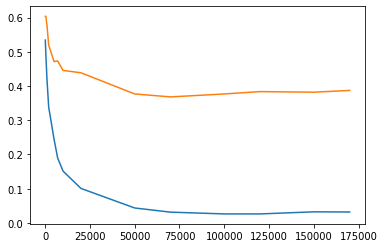

In [98]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(num_features, train_error)
ax.plot(num_features, dev_error)
#ax.set_xscale('log')

In [99]:
min_ngram = [2,3,4,5,6]
max_ngram = [10,13,15,17,20]
max_features = [60000,65000,70000,75000,80000]
        
classifier = MultinomialNB()
    
for max_ngram, min_ngram, max_features in parameter_grid(max_ngram,min_ngram,max_features):
    
    vectorizer = nlp.BagOfNgramsVectorizer(label_fn=label_fn,tokenizer=nlp.tokenize_characters,
                                           ngram_range=(min_ngram,max_ngram),max_features=max_features)

    score = nlp.train_dev_validation(model=classifier,
                                     train_dataset=train_dataset,
                                     dev_dataset=train_dataset,
                                     vectorizer=vectorizer,
                                     metric=['accuracy','f1_macro'])

    print('Ngram range: ({},{}). Max features: {}'.format(min_ngram,max_ngram,max_features))
    print('Scores for the train dataset evaluation:')
    print(score)

    score = nlp.train_dev_validation(model=classifier,
                                     train_dataset=train_dataset,
                                     dev_dataset=dev_dataset,
                                     vectorizer=vectorizer,
                                     metric=['accuracy','f1_macro'])

    print('Scores for the development dataset evaluation:')
    print(score)
    print()

Ngram range: (2,10). Max features: 60000
Scores for the train dataset evaluation:
{'accuracy': 0.9601500234411627, 'f1_macro': 0.9574014845575349}
Scores for the development dataset evaluation:
{'accuracy': 0.6265060240963856, 'f1_macro': 0.49387456650761347}

Ngram range: (2,10). Max features: 65000
Scores for the train dataset evaluation:
{'accuracy': 0.9662447257383966, 'f1_macro': 0.9633518105292926}
Scores for the development dataset evaluation:
{'accuracy': 0.6265060240963856, 'f1_macro': 0.4958457134870682}

Ngram range: (2,10). Max features: 70000
Scores for the train dataset evaluation:
{'accuracy': 0.9681200187529302, 'f1_macro': 0.966299758060716}
Scores for the development dataset evaluation:
{'accuracy': 0.6299483648881239, 'f1_macro': 0.5012785423829246}

Ngram range: (2,10). Max features: 75000
Scores for the train dataset evaluation:
{'accuracy': 0.9699953117674637, 'f1_macro': 0.9687121207723728}
Scores for the development dataset evaluation:
{'accuracy': 0.62822719449

Scores for the development dataset evaluation:
{'accuracy': 0.6247848537005164, 'f1_macro': 0.4932671455210217}

Ngram range: (3,13). Max features: 70000
Scores for the train dataset evaluation:
{'accuracy': 0.9639006094702297, 'f1_macro': 0.9623865327844359}
Scores for the development dataset evaluation:
{'accuracy': 0.6230636833046471, 'f1_macro': 0.49246714552102167}

Ngram range: (3,13). Max features: 75000
Scores for the train dataset evaluation:
{'accuracy': 0.9704641350210971, 'f1_macro': 0.9682445026802171}
Scores for the development dataset evaluation:
{'accuracy': 0.6265060240963856, 'f1_macro': 0.49810334610941687}

Ngram range: (3,13). Max features: 80000
Scores for the train dataset evaluation:
{'accuracy': 0.9718706047819972, 'f1_macro': 0.9692630095813499}
Scores for the development dataset evaluation:
{'accuracy': 0.6265060240963856, 'f1_macro': 0.4977530532685549}

Ngram range: (3,15). Max features: 60000
Scores for the train dataset evaluation:
{'accuracy': 0.95686826

Scores for the development dataset evaluation:
{'accuracy': 0.6265060240963856, 'f1_macro': 0.5162845681450332}

Ngram range: (4,15). Max features: 80000
Scores for the train dataset evaluation:
{'accuracy': 0.9685888420065635, 'f1_macro': 0.9648307044724538}
Scores for the development dataset evaluation:
{'accuracy': 0.6265060240963856, 'f1_macro': 0.5111968869284345}

Ngram range: (4,17). Max features: 60000
Scores for the train dataset evaluation:
{'accuracy': 0.9615564932020628, 'f1_macro': 0.9580822946160453}
Scores for the development dataset evaluation:
{'accuracy': 0.6144578313253012, 'f1_macro': 0.5014529735156539}

Ngram range: (4,17). Max features: 65000
Scores for the train dataset evaluation:
{'accuracy': 0.9662447257383966, 'f1_macro': 0.9634002440036915}
Scores for the development dataset evaluation:
{'accuracy': 0.6196213425129088, 'f1_macro': 0.508415840214353}

Ngram range: (4,17). Max features: 70000
Scores for the train dataset evaluation:
{'accuracy': 0.96905766526

Scores for the development dataset evaluation:
{'accuracy': 0.6161790017211703, 'f1_macro': 0.5177187250652348}

Ngram range: (5,20). Max features: 65000
Scores for the train dataset evaluation:
{'accuracy': 0.9592123769338959, 'f1_macro': 0.9548545749183495}
Scores for the development dataset evaluation:
{'accuracy': 0.6144578313253012, 'f1_macro': 0.5136739986290839}

Ngram range: (5,20). Max features: 70000
Scores for the train dataset evaluation:
{'accuracy': 0.9615564932020628, 'f1_macro': 0.9569533762319208}
Scores for the development dataset evaluation:
{'accuracy': 0.612736660929432, 'f1_macro': 0.5113637784741937}

Ngram range: (5,20). Max features: 75000
Scores for the train dataset evaluation:
{'accuracy': 0.9629629629629629, 'f1_macro': 0.9588245476877039}
Scores for the development dataset evaluation:
{'accuracy': 0.6161790017211703, 'f1_macro': 0.5097238072353218}

Ngram range: (5,20). Max features: 80000
Scores for the train dataset evaluation:
{'accuracy': 0.96436943272

## Variando el parámetro de regularización alpha

In [8]:
from NLPUtils.datasets import tass2018 as tass8
from NLPUtils.datasets import tass2019 as tass9
from NLPUtils.classifiers import MultinomialNB

train_dataset = pd.concat([tass8.get_train_dataframe(lang=['es']), tass9.get_train_dataframe(lang=['es'])],ignore_index=True)
dev_dataset = tass9.get_dev_dataframe(lang=['es'])

def label_fn(labels):
    labels_dict = {label: idx for idx, label in enumerate(np.unique(labels))}
    return np.array([labels_dict[label] for label in labels])

alphas = [.01, .02, .04, .06, .1, .5, 1., 2., 4., 10.]
ngram_range=(3,10)
max_features = 70000

for alpha in alphas:
    
    classifier = MultinomialNB(alpha=alpha)
    vectorizer = nlp.BagOfNgramsVectorizer(label_fn=label_fn,tokenizer=nlp.tokenize_characters,
                                           ngram_range=ngram_range,max_features=max_features)

    vectorized_train_dataset = vectorizer.fit_transform(train_dataset)
    classifier.train(vectorized_train_dataset)
    y_dev, y_predict = classifier.predict(vectorized_train_dataset)
    score = nlp.get_score(y_dev,y_predict,metrics=['accuracy','f1_macro'])

    print('Ngram range: ({},{}). Max features: {}. alpha: {}'.format(ngram_range[0],ngram_range[1],max_features,alpha))
    print('Scores for the train dataset evaluation:')
    print(score)
    
    vectorized_dev_dataset = vectorizer.transform(dev_dataset)
    y_dev, y_predict = classifier.predict(vectorized_dev_dataset)
    score = nlp.get_score(y_dev,y_predict,metrics=['accuracy','f1_macro'])
    
    print('Scores for the development dataset evaluation:')
    print(score)
    print()

Ngram range: (3,10). Max features: 70000. alpha: 0.01
Scores for the train dataset evaluation:
{'accuracy': 0.9957805907172996, 'f1_macro': 0.9961120815052038}
Scores for the development dataset evaluation:
{'accuracy': 0.6437177280550774, 'f1_macro': 0.5280215396888711}

Ngram range: (3,10). Max features: 70000. alpha: 0.02
Scores for the train dataset evaluation:
{'accuracy': 0.9948429442100328, 'f1_macro': 0.9951436929763909}
Scores for the development dataset evaluation:
{'accuracy': 0.6419965576592083, 'f1_macro': 0.5289097266054207}

Ngram range: (3,10). Max features: 70000. alpha: 0.04
Scores for the train dataset evaluation:
{'accuracy': 0.9929676511954993, 'f1_macro': 0.992870351917353}
Scores for the development dataset evaluation:
{'accuracy': 0.6368330464716007, 'f1_macro': 0.5335897682924771}

Ngram range: (3,10). Max features: 70000. alpha: 0.06
Scores for the train dataset evaluation:
{'accuracy': 0.992498827941866, 'f1_macro': 0.9922805650505627}
Scores for the developm

## Armamos los resultados para test

In [101]:
train_dataset = pd.concat([tass8.get_train_dataframe(lang=['es']), tass9.get_train_dataframe(lang=['es'])],ignore_index=True)
dev_dataset = tass8.get_dev_dataframe(lang=['es'])

classifier = MultinomialNB()
vectorizer = nlp.BagOfNgramsVectorizer(label_fn=label_fn,tokenizer=nlp.tokenize_characters,
                                       ngram_range=(4,20),max_features=80000)

score = nlp.train_dev_validation(model=classifier,
                                 train_dataset=train_dataset,
                                 dev_dataset=train_dataset,
                                 vectorizer=vectorizer,
                                 metric=['accuracy','f1_macro'])

print('Ngram range: ({},{}). Max features: {}'.format(min_ngram,max_ngram,max_features))
print('Scores for the train dataset evaluation:')
print(score)

score = nlp.train_dev_validation(model=classifier,
                                 train_dataset=train_dataset,
                                 dev_dataset=dev_dataset,
                                 vectorizer=vectorizer,
                                 metric=['accuracy','f1_macro'])

print('Scores for the development dataset evaluation:')
print(score)
print()

Ngram range: (6,20). Max features: 80000
Scores for the train dataset evaluation:
{'accuracy': 0.9695264885138303, 'f1_macro': 0.9657830093438701}
Scores for the development dataset evaluation:
{'accuracy': 0.5869565217391305, 'f1_macro': 0.48072937254898174}



In [55]:
train_df = tass.get_train_dataframe(lang=['es'])
test_df = tass.get_test_dataframe(lang=['es'])
test_df['label'] = 'N'

def label_fn(labels):
    labels_dict = {label: idx for idx, label in enumerate(np.unique(labels))}
    return np.array([labels_dict[label] for label in labels])

vectorizer = nlp.BagOfNgramsVectorizer(label_fn=label_fn)
X_train,y_train = vectorizer.fit_transform(train_df)

classifier = MultinomialNB()
classifier.train((X_train,y_train))

X_test, y_test = vectorizer.transform(test_df.loc[:,['text','label']])
_, y_predict = classifier.predict((X_test,y_test))

labels_to_idx = {label: idx for idx, label in enumerate(np.unique(train_df['label']))}
idx_to_labels = {idx:label for label, idx in labels_to_idx.items()}
labels_predict = [idx_to_labels[idx] for idx in y_predict]
test_df['label'] = labels_predict
test_df.loc[:,['tweet_id','label']].to_csv('./test_results.tsv',sep='\t',index=False,header=False)


In [56]:
test_df.head()

,tweet_id,text,label
0,770567971701940224,@LonelySoad mientras que no te pillen la prime...,N
1,770503386789711872,@ceemeese ya era hora de volver al csgo y deja...,N
2,770502863017635840,@mireiaescribano justo cuando se terminan las ...,N
3,770599972102348800,@LuisMartinez22_ pensba q iba a hacer @wxplosi...,N
4,770599962216390656,"@Vic_Phantomhive Si lo encuentro, sin compañer...",N
